## Crow-AMSAA Analysis - Reliability Growth Tracking

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.offsetbox import AnchoredText
from matplotlib.ticker import ScalarFormatter
import seaborn as sns
sns.set()
from scipy.stats.distributions import chi2
import random as rd
import math
import warnings
warnings.filterwarnings("ignore")

In [2]:
def Crow_AMSAA(df,type='ft'):
    '''
    This function creates a Crow-AMSAA plot.
    
    Input parameters:
    - df = Dataframe with a column 't' with cumulative failure times in a number format (no datetime format). Test starts at t=0.
    - type = 'ft' as default: 'ft' = Failure Truncated Test (Test ends at the last failure time)
    You can change the type to 'tt' = Time Truncated Test (The last datapoint is the end time of the test, which is not the time of the last failure.)
    
    Outputs:
    - table with 'Failure Event Indices', 'Failure times' and 'Times Between Failure' (TBF)
    - plot 'Failure Event Indices' vs. TBF
    - Crow-AMSAA Plot in log-log scale with the folowing information:
        - model parameters (beta and lambda)
        - instantaneous Mean Time Between Failure (MBTF)
        - prediction of the time of the next Failure Event
        - confidence interval of the prediction
        - an evaluation of the Null hypothesis (H0 = No Reliability growth') (Chi²-test)
        - an evaluation of the goodness of fit of the Crow-AMSAA-model (Cramér-von Mises-test)
    '''
    
    UL = 0 #---------------------------------------------------------- Initialize two parameters used in layout plots
    UL2 = 0
    
    # Creation of dataframe with Critical Values for Cramér-von Mises Test with a significance level of 10%:
    # ======================================================================================================
    # Table covers critical values upto N=59 datapoints. N>=60: critical value = 0.173
    # First values (N=2-20):
    critval = [0.162, 0.154, 0.155, 0.16, 0.162, 0.165, 0.165, 0.167, 0.167, 0.169, 0.169, 0.169, 0.169, 0.169, 0.171, 0.171, 0.171, 0.171, 0.172]
    critical_values = pd.DataFrame(index = range(2,21),columns = ['Number','Crit_Val'])
    critical_values.Number = list(range(2,21))
    critical_values.Crit_Val = critval
    # Next values (N=21-59):
    critical_values2 = pd.DataFrame(index=range(21,60),columns=['Number','Crit_Val'])
    critical_values2.Number = list(range(21,60))
    critical_values2.Crit_Val = 0.172
    critical_values = pd.concat([critical_values,critical_values2],0)
    
    # Maximum Likelihood Estimation:
    # ==============================
    if type == 'ft':
        N = len(df) #------------------------------------------------- Total number of Failure Events
    else:
        N = len(df)-1
    T = df.t[len(df) - 1] #------------------------------------------- Total test time
    S = 0
    for i in range(N-1):
        S += np.log(T / df.t[i]) #------------------------------------ Sum of log(relative failure times)
    Beta = N/S #------------------------------------------------------ MLE beta parameter
    if N < 20:
        if type == 'ft':
            Beta_c = (N - 2)/(N) * Beta #----------    --------------- Bias Correction
        else:
            Beta_c = (N - 1) / N * Beta
    else:
        Beta_c = Beta
    Lambda = N / (T ** Beta_c) #-------------------------------------- MLE lambda parameter (scale parameter)
    IFR = Lambda * Beta_c * (T ** (Beta_c-1)) #----------------------- Instantaneous Failure Rate
    IMTBF = 1/IFR #--------------------------------------------------- Instantaneous MTBF
    NE = ((N + 1) / Lambda) ** (1 / Beta_c) #------------------------- Prediction Time Next Failure Event
    LL = IMTBF * (0.1598 * np.log(N) + 0.0536) #---------------------- Lower Limt of Prediction Interval (90% confidence)
    UL = IMTBF / (0.1998 * np.log(N) - 0.1297) #---------------------- Upper Limt of Prediction Interval (90% confidence)
    
    # Hypothesis Testing:
    # ===================
    ChiSqr = 2 * N / Beta_c #----------------------------------------- Chi-squared test statistic
    if type == 'ft':
        DF = 2 * (N - 1) #-------------------------------------------- Degrees of freedom
    else:
        DF = 2 * N
    LCV = chi2.ppf(0.05, df = DF) #----------------------------------- Lower Critical Value (10% significance level)
    UCV = chi2.ppf(0.95, df = DF) #----------------------------------- Upper Critical Value (10% significance level)
    
    if ChiSqr > LCV and ChiSqr < UCV: #------------------------------- Setting Text for Evaluation of Null hypothesis + colors of plots
        H0 = 'The null hypothesis that no reliability' + '\n' + \
        'growth is taking place cannot be' +'\n' + \
        'rejected at the 10% significance level'
        clr = 'b'
        Growth = False
    else:
        Growth = True
        if ChiSqr <= LCV:
            H0 = 'The null hypothesis that no reliability' + '\n' + \
            'reduction is taking place is rejected' + '\n' + \
            'at the 10% significance level'
            clr = 'r'
            Reliability_Increase = False
        else:
            H0 = 'The null hypothesis that no reliability' + '\n' + \
            'growth is taking place is rejected' + '\n' + \
            'at the 10% significance level'
            clr = 'g'
            Reliability_Increase = True
            
    # Model Validity Tetsing (Cramér-von Mieses):
    # ===========================================
    CvM = 0 #--------------------------------------------------------------------- Initialize Cramér-von Mises Statistic
    if type == 'ft':
        M = N - 1
    else:
        M = N
    for i in range(N - 1):
        CvM += ((df.t[i] / T) ** Beta_c - (2 * (i + 1) - 1) / (2 * M)) ** 2
    CvM += 1 / (12 * M)
    if N < 60:
        CV_CvM = critical_values.iat[N-3,1]  #------------------------------------ Critical Value Cramér-von Mises Test
    else:
        CV_CvM = 0.173
    if CvM <= CV_CvM:  #---------------------------------------------------------- Setting Text for Model Acceptance Test + plot line types
        Fit = 'Crow-AMSAA model is accepted'
        line = '-'
        Not_Accepted = False
    else:
        Fit = 'Crow-AMSAA model is not accepted'
        line = '--'
        Not_Accepted = True
        
    # Create data for Event index Number (N) and TBF:
    # ===============================================
    df['N'] = df.index + 1 #------------------------------------------------------ Add Event Number 
    df['TBF'] = 0
    for i in range(1, len(df)):
        df.TBF[i] = df.t[i] - df.t[i-1]
    df.TBF[0] = df.t[0]
    df = df[['N','t','TBF']] #--------------------------------------------------- Reorder culumns
    df['t'] = df['t'].astype(float).round(2)
    df['TBF'] = df['TBF'].astype(float).round(2)
        
    # Plotting the results:
    # =====================
    
    # Setting up plot layout:
    fig = plt.figure(figsize=(22,10))
    ax1 = plt.subplot2grid(shape=(3,5), loc=(0, 0), colspan=1, rowspan=3)
    ax2 = plt.subplot2grid(shape=(3,5), loc=(0, 1), colspan=4, rowspan=1)
    ax3 = plt.subplot2grid(shape=(3,5), loc=(1, 1), colspan=4, rowspan=2)
    
    # Table Plot:
    ax1.axis('off')
    ax1.axis('tight')
    tbl = ax1.table(cellText = df.values, colLabels=df.columns, loc='best')
    ax1.set_title('Failure Data', fontsize=20)
    tbl.set_fontsize(12)
    tbl.scale(1,1.5)
    
    # Plot TBF:
    ax2.plot(df.N, df.TBF, '--', marker='s', c = 'magenta', alpha=.5)
    ax2.plot([1, len(df)], [IMTBF, IMTBF], c = clr, label='Instantaneous MTBF = ' + str(round(IMTBF)))
    ax2.plot([1, len(df)], [df.TBF.mean(), df.TBF.mean()], c='purple', label='MTBF data = ' + str(round(df.TBF.mean())))
    ax2.grid(True)
    ax2.legend(fontsize=14)
    ax2.set_xticks(df.index+1)
    ax2.set_xlabel('Failure Event Index Number', fontsize=14)
    ax2.set_ylabel('TBF', fontsize=14)
    
    # Plot Events
    if type=='ft': 
        ax3.scatter(df.t, df.index + 1, c='magenta', marker='s', s = 50, label = 'Failure Times vs. Event Index Number', alpha=.5)
    else:
        ax3.scatter(df.t[:-2], df.index[:-2] + 1, c='magenta', marker='s', s = 50, label = 'Failure Times vs. Event Index Number', alpha=.5)
    
    def Model(p):
        return Lambda * p ** Beta_c
    
    # Plot Model
    x = np.linspace(1, (N / Lambda) ** (1 / Beta_c),100)
    y = Model(x)
    ax3.plot(x, y, line, c = clr, label = 'Fitted Model')
    
    # Plot Prediction
    x = np.linspace((N / Lambda) ** (1 / Beta_c), ((N+1) / Lambda) ** (1 / Beta_c),100)
    y = Model(x)
    ax3.plot(x, y, ':', c = clr)
    x = [((N + 1) / Lambda) ** (1 / Beta_c)]
    y = Model(x)
    ax3.scatter(x, y, marker = '*', s = 200, c = 'orange', label = 'Prediction Next Event', zorder=1000)
    x = [T + LL]
    LL2 = x
    ax3.scatter(x, y, marker = '>', s = 100, c = 'orange', label = 'Lower Prediction Limit')
    x = [T + UL]
    UL2 = x
    ax3.scatter(x, y, marker= '<', s = 100, c = 'orange', label = 'Upper Prediction Limit')
    
    # Layout
    ax3.set_xlabel('Cumulative Failure Times', fontsize=14)
    ax3.set_ylabel('Failure Event Index Number', fontsize=14)
    if type=='ft':
        termination_type = 'Failure Truncated Test'
    else:
        termination_type = 'Time Truncated Test'
    ax3.set_title('Crow-AMSAA Analysis - ' + termination_type, fontsize = 20)
    ax3.grid(True, 'minor')
    ax3.grid(True, 'major')
    ax3.legend(loc = 'lower right')
    ax3.set_xscale('log')
    ax3.set_yscale('log')
    ax3.set_ylim(.9, N + 2)
    
    minimum = df.t.min()
    m = 10**(math.floor(math.log(minimum, 10)))
    maximum = max([UL, UL2])[0]
    M = 10**(math.floor(math.log(maximum, 10)))
    minimum = math.trunc(minimum / m) * m
    maximum = math.ceil(maximum / M) * M
    ax3.set_xlim(minimum, maximum)
    ax3.set_xticks(range(minimum, maximum, int(M / 2)))
    ax3.set_yticks(range(1, N+3, 1))
    
    ax3.xaxis.set_major_formatter(ScalarFormatter())
    ax3.yaxis.set_major_formatter(ScalarFormatter())
    ax3.xaxis.set_minor_formatter(ScalarFormatter())
    ax3.yaxis.set_minor_formatter(ScalarFormatter())
    
    textstr = '\n'.join(('N = ' + str(N), r'$\beta=%.2f$' % (Beta_c, ),\
                         r'$\lambda=%.10f$' % (Lambda, ) + '\n',\
                         'Instantaneous MTBF = ' + str(round(IMTBF,1)) + ' units of time',\
                         'Next Event at: t = ' + str(round(NE,1)),\
                         'LL at: t = ' + str(round(LL2[0],1)),\
                         'UL at: t = ' + str(round(UL2[0],1)) + '\n',\
                         H0 + '\n', \
                         Fit))
    
    props = dict(boxstyle = 'round', facecolor = 'white', alpha = 0.5)
    ax3.text(0.015, 0.98, textstr, transform = plt.gca().transAxes, fontsize = 15, va = 'top', linespacing = 1.5, bbox = props)
    
    if Not_Accepted == True:
        at = AnchoredText(
            Fit, prop = dict(size = 20, color = 'r', fontweight = 'bold'), frameon = False, loc = 'lower center')
    else:
        at = AnchoredText(
            Fit, prop = dict(size = 20, color = 'g', fontweight = 'bold'), frameon = False, loc = 'lower center')
    ax3.add_artist(at)
    
    if Growth == False:
        at = AnchoredText(
            'No Statistical Evidence of' + '\n' \
            + 'Reliability Growth nor Decrease', \
            prop = dict(size = 20, color = 'b', fontweight =  'bold'), frameon = False, loc = 'upper center')
    else:
        if Reliability_Increase == True:
            at = AnchoredText(
                'Statistical Evidence of' + '\n' \
                + 'Reliability Growth', \
                prop = dict(size = 20, color = 'g', fontweight = 'bold'), frameon = False, loc = 'upper center')
        else:
            at = AnchoredText(
                'Statistical Evidence of' + '\n' \
                + 'Decrease in Reliability', \
                prop = dict(size = 20, color = 'r', fontweight = 'bold'), frameon = False, loc = 'upper center')
    ax3.add_artist(at)
    
    plt.tight_layout()
    plt.show()
        

In [3]:
def generate_failure_times(number, beta, eta, type = 'abao'):
    '''
    For playing around with the Crow_AMSAA function, you can generate failure times based on a Weibull Model.
    
    Parameters:
    - number = number of failures
    - beta = shape parameter of the weibull function (]0, real positive number])
    - eta = scale parameter of the weibull function (real positive number)
    - type = 'abao' (default) abao = 'As Bad as Old' this means that the repair of the asset results in the same hazard rate at the moment of the last failure.
    You can change it to 'agan' (or any other text string :)) = 'As Good as New', which means that the asset is replaced after failure or the hazard rate is set back to zero after repair.
    'agan' will normally result in 'no reliability growth nor decrease'
    'abao' will  ormally result in 'reliability growth' for beta < 1 and in 'reliability decrease' for beta > 1
    
    '''
    
    # Defining Weibull functions
    def R(x): # ----------------------------------------------------------- Reliability Function
        return np.exp(-(x/eta)**beta)
    
    def Rc(x,x1): # ------------------------------------------------------- Conditional Reliability Function = Reliability Function under the condition that the asset survived to time x1
        return R(x)/R(x1)
    
    def Hc(x,x1):
        return -np.log(Rc(x,x1)) # ---------------------------------------- Conditional Cumulative Hazard Rate Function = Cumulative Hazard Rate Function under the condition that the asset survived to time x1
    
    
    dfr = pd.DataFrame(index = range(number), columns = ['t']) #----------- Dataframe with the simulated failure times
        
    # Simulation
    dt  = eta / 10000 #---------------------------------------------------- Time increment used in the simulation
    CT = 0 #--------------------------------------------------------------- Initializing CT= Conditional Age of asset, ST= System time, VT= Virtual Age of the asset
    ST = 0
    VT = 0
    for i in range(number):
        failed = False
        while failed == False:
            if rd.random() < Hc(VT+dt,CT)-Hc(VT,CT):
                dfr.t[i] = ST + dt
                failed = True
            else:
                VT += dt
                ST += dt
        if type == 'abao': #------------------------------------------------ You could also generate a 'number' amount of equally distributed random numbers between 0 and 1
                           #------------------------------------------------ and calculate the inverse of the Cumulative Distributiin Function (Not included here).
            VT = ST
            CT = ST
        else:
            VT = 0
            CT = 0
        
    return dfr

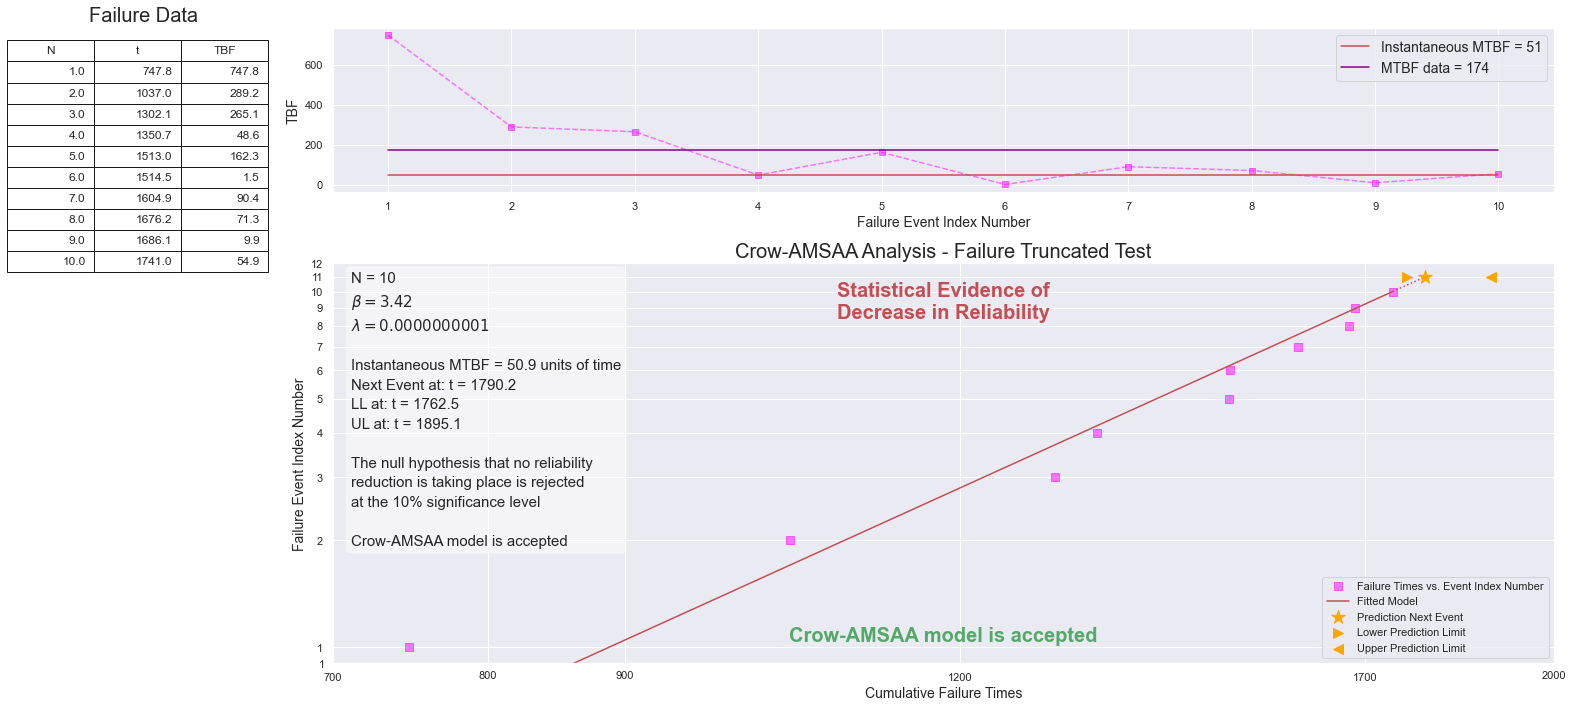

In [6]:
# Example: generate 10 failures of a repairable system with a Weibull distributed failure behaviour (beta=3, eta=1000). Repair results in a condition "as bad as old".
data = generate_failure_times(10, 3, 1000, type = 'abao')
Crow_AMSAA(data,'ft')